# Homework 1, DS-GA 1012, Spring 2019

## Due Feburary 13, 2019 at 2pm (ET)

Download the data zip `DS-GA1012-hw1-data.zip`. Complete the following questions in the notebook and submit your completed notebook on NYU Classes.

## set environment

In [0]:
from collections import defaultdict
import numpy as np
from numpy.linalg import svd
import matplotlib.pyplot as plt

In [0]:
%matplotlib inline

## 1. Exploring effect of context size [30 pts]

We face many implicit and explicit design decisions in creating distributional word representations. For example, in lecture and in lab, we created word vectors using a co-occurence matrix built on neighboring pairs of words. We might suspect, however, that we can get more signal of word similarity by considering larger contexts than pairs of words.

__a__. Write `build_cooccurrence_matrix`, which generates the co-occurence matrix for a window of arbitrary size and for the vocabulary of `max_vocab_size` most frequent words. Feel free to modify the code used in lab [10 pts]

In [0]:
#Yusu's homework
import time
from collections import defaultdict

def build_cooccurrence_matrix(data, max_vocab_size=20000,context_size=1):
    """ 
    
    args:
        - data: iterable where each item is a string sentence
        - max_vocab_size: maximum vocabulary size
        
    returns:
        - coocur_mat: co-occurrence matrix as a numpy array
    """
    
    def get_token_frequencies():
        tok2freq = defaultdict(int)
        coocur_counts = defaultdict(lambda: defaultdict(int))

        for datum in data:
            tokens = datum.strip().split() # we'll use whitespace to tokenize
            for i, tok in enumerate(tokens):
                tok2freq[tok] += 1
                coocur_counts[tok][tok] += 1
                if i < len(tokens) - 1:
                    coocur_counts[tok][tokens[i+1]] += 1
                    coocur_counts[tokens[i+1]][tok] += 1
        return tok2freq, coocur_counts
    
    def prune_vocabulary(tok2freq, max_vocab_size):
        """ Prune vocab by taking max_vocab_size most frequent words """
        tok_and_freqs = [(k, v) for k, v in tok2freq.items()]
        tok_and_freqs.sort(key = lambda x: x[1], reverse=True) # sorts in-place
        tok2idx = {tok: idx for idx, (tok, _) in enumerate(tok_and_freqs[:max_vocab_size])}
        idx2tok = {idx: tok for tok, idx in tok2idx.items()}
        return tok2idx, idx2tok
    
    def _build_coocurrence_mat(idx2tok, coocur_counts):
        mat = [[coocur_counts[idx2tok[i]][idx2tok[j]] for j in range(len(idx2tok))] for i in range(len(idx2tok))]
        """vocab_size = len(idx2tok)
        mat = [[0 for _ in range(vocab_size)] for _ in range(vocab_size)]
        for i in range(vocab_size - context_size):
            for j in range(i+context_size, vocab_size):
                if coocur_counts[idx2tok[i]][idx2tok[j]]:
                    mat[i][j] = coocur_counts[idx2tok[i]][idx2tok[j]]
                    mat[j][i] = coocur_counts[idx2tok[i]][idx2tok[j]]"""
        return np.array(mat)
        
    print("Counting words...")
    start_time = time.time()
    tok2freq, coocur_counts = get_token_frequencies()
    print("\tFinished counting words in %.5f" % (time.time() - start_time))

    print("Pruning vocabulary...")
    tok2idx, idx2tok = prune_vocabulary(tok2freq, max_vocab_size)
    start_time = time.time()
    print("\tFinished pruning vocabulary in %.5f" % (time.time() - start_time))
    
    print("Building co-occurrence matrix...")
    start_time = time.time()
    coocur_mat = _build_coocurrence_mat(idx2tok, coocur_counts)
    print("\tFinished building co-occurrence matrix in %.5f" % (time.time() - start_time))
    return coocur_mat, tok2idx, idx2tok

Use your implementation of `build_cooccurrence_matrix` to generate the co-occurence matrix from the sentences of [SST](http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip) (file `datasetSentences.txt`) with `context_size=2` and `max_vocab_size=10000`. What is the co-occurrence count of the words "the" and "end"? 

In [0]:
def load_sst(data_file):
    with open(data_file, 'r') as data_fh:
        data_fh.readline() # skip the header
        data = [r.split('\t')[1] for r in data_fh.readlines()]
    return data

In [5]:
data_file = 'datasetSentences.txt'

data = load_sst(data_file)
mat, tok2idx, idx2tok = build_cooccurrence_matrix(data, max_vocab_size=10000,context_size=1)

Counting words...
	Finished counting words in 0.41888
Pruning vocabulary...
	Finished pruning vocabulary in 0.00000
Building co-occurrence matrix...
	Finished building co-occurrence matrix in 54.01308


In [6]:
mat

array([[11162,     0,     0, ...,     0,     0,     1],
       [    0,  9949,   466, ...,     0,     0,     0],
       [    0,   466,  8395, ...,     0,     0,     0],
       ...,
       [    0,     0,     0, ...,     2,     0,     0],
       [    0,     0,     0, ...,     0,     2,     0],
       [    1,     0,     0, ...,     0,     0,     2]])

In [7]:
#find the index of 'the'
list(tok2idx.keys()).index("the")

2

In [8]:
#find the index of 'and'
list(tok2idx.keys()).index("and")

3

In [9]:
#find the cooccurence of 'the' and 'and'
mat[2][3]

348

In [0]:
#save for later
mat_1=mat

__b__. Plot the effect of varying context size in $\{1, 2, 3, 4\}$ (leaving all the other settings the same) on the quality of the learned word embeddings, as measured by performance (Spearman correlation) on the word similarity dataset [MTurk-771](http://www2.mta.ac.il/~gideon/mturk771.html) between human judgments and cosine similarity of the learned word vectors (see lab). [12 pts]

Evaluation: Word Similarity

In [0]:
from scipy.stats import spearmanr

In [0]:
def load_word_similarity_dataset(data_file):
    with open(data_file, 'r') as data_fh:
        raw_data = data_fh.readlines()
    data = []
    trgs = []
    for datum in raw_data:
        datum = datum.strip().split(',')
        data.append((datum[0], datum[1]))
        trgs.append(float(datum[2]))
    return data, trgs

In [0]:
test_file = 'MTURK-771.csv'
test_data, test_trgs = load_word_similarity_dataset(test_file)

Here we evaluate when context_size=1.

In [0]:
def evaluate_word_similarity(word_pairs, targets, mat, tok2idx):
    """ """
    preds = []
    trgs = []
    n_exs = 0
    for (word1, word2), trg in zip(word_pairs, targets):
        if word1 in tok2idx and word2 in tok2idx:
            pred_sim = 1 - cosine(mat[tok2idx[word1]], mat[tok2idx[word2]])
            preds.append(pred_sim)
            trgs.append(trg)
            n_exs += 1
    
    rho, pvalue = spearmanr(trgs, preds)
    print("Evaluated on %d of %d examples" % (n_exs, len(word_pairs)))
    return rho
def vector_length(u):
    """Length (L2) of the 1d np.array `u`. Returns a new np.array with the 
    same dimensions as `u`."""
    return np.sqrt(np.dot(u, u))
  
def cosine(u, v):        
    """Cosine distance between 1d np.arrays `u` and `v`, which must have 
    the same dimensionality. Returns a float."""
    return 1.0 - (np.dot(u, v) / (vector_length(u) * vector_length(v)))
  
def prob_norm(u):
    """Normalize 1d np.array `u` into a probability distribution. Assumes 
    that all the members of `u` are positive. Returns a 1d np.array of 
    the same dimensionality as `u`."""
    return u / np.sum(u)

def rowwise_norm_mat(mat):
    return np.array([prob_norm(u) for u in mat])
norm_mat = rowwise_norm_mat(mat)

In [16]:
evaluation1=evaluate_word_similarity(test_data, test_trgs, norm_mat, tok2idx)
evaluation1

Evaluated on 248 of 771 examples


-0.015468056503250562

Here we evaluate when context_size=2.

In [17]:
mat, tok2idx, idx2tok = build_cooccurrence_matrix(data, max_vocab_size=10000,context_size=2)

Counting words...
	Finished counting words in 0.46556
Pruning vocabulary...
	Finished pruning vocabulary in 0.00000
Building co-occurrence matrix...
	Finished building co-occurrence matrix in 51.72593


In [0]:
def evaluate_word_similarity(word_pairs, targets, mat, tok2idx):
    """ """
    preds = []
    trgs = []
    n_exs = 0
    for (word1, word2), trg in zip(word_pairs, targets):
        if word1 in tok2idx and word2 in tok2idx:
            pred_sim = 1 - cosine(mat[tok2idx[word1]], mat[tok2idx[word2]])
            preds.append(pred_sim)
            trgs.append(trg)
            n_exs += 1
    
    rho, pvalue = spearmanr(trgs, preds)
    print("Evaluated on %d of %d examples" % (n_exs, len(word_pairs)))
    return rho
def vector_length(u):
    """Length (L2) of the 1d np.array `u`. Returns a new np.array with the 
    same dimensions as `u`."""
    return np.sqrt(np.dot(u, u))
  
def cosine(u, v):        
    """Cosine distance between 1d np.arrays `u` and `v`, which must have 
    the same dimensionality. Returns a float."""
    return 1.0 - (np.dot(u, v) / (vector_length(u) * vector_length(v)))
  
def prob_norm(u):
    """Normalize 1d np.array `u` into a probability distribution. Assumes 
    that all the members of `u` are positive. Returns a 1d np.array of 
    the same dimensionality as `u`."""
    return u / np.sum(u)

def rowwise_norm_mat(mat):
    return np.array([prob_norm(u) for u in mat])
norm_mat = rowwise_norm_mat(mat)

In [19]:
evaluation2=evaluate_word_similarity(test_data, test_trgs, norm_mat, tok2idx)
evaluation2

Evaluated on 248 of 771 examples


-0.015468056503250562

Here we evaluate when context_size=3.

In [20]:
mat, tok2idx, idx2tok = build_cooccurrence_matrix(data, max_vocab_size=10000,context_size=3)

Counting words...
	Finished counting words in 0.53564
Pruning vocabulary...
	Finished pruning vocabulary in 0.00000
Building co-occurrence matrix...
	Finished building co-occurrence matrix in 51.25811


In [0]:
def evaluate_word_similarity(word_pairs, targets, mat, tok2idx):
    """ """
    preds = []
    trgs = []
    n_exs = 0
    for (word1, word2), trg in zip(word_pairs, targets):
        if word1 in tok2idx and word2 in tok2idx:
            pred_sim = 1 - cosine(mat[tok2idx[word1]], mat[tok2idx[word2]])
            preds.append(pred_sim)
            trgs.append(trg)
            n_exs += 1
    
    rho, pvalue = spearmanr(trgs, preds)
    print("Evaluated on %d of %d examples" % (n_exs, len(word_pairs)))
    return rho
def vector_length(u):
    """Length (L2) of the 1d np.array `u`. Returns a new np.array with the 
    same dimensions as `u`."""
    return np.sqrt(np.dot(u, u))
  
def cosine(u, v):        
    """Cosine distance between 1d np.arrays `u` and `v`, which must have 
    the same dimensionality. Returns a float."""
    return 1.0 - (np.dot(u, v) / (vector_length(u) * vector_length(v)))
  
def prob_norm(u):
    """Normalize 1d np.array `u` into a probability distribution. Assumes 
    that all the members of `u` are positive. Returns a 1d np.array of 
    the same dimensionality as `u`."""
    return u / np.sum(u)

def rowwise_norm_mat(mat):
    return np.array([prob_norm(u) for u in mat])
norm_mat = rowwise_norm_mat(mat)

In [22]:
evaluation3=evaluate_word_similarity(test_data, test_trgs, norm_mat, tok2idx)
evaluation3

Evaluated on 248 of 771 examples


-0.015468056503250562

Here we evaluate when context_size=4.

In [23]:
mat, tok2idx, idx2tok = build_cooccurrence_matrix(data, max_vocab_size=10000,context_size=4)

Counting words...
	Finished counting words in 0.42914
Pruning vocabulary...
	Finished pruning vocabulary in 0.00000
Building co-occurrence matrix...
	Finished building co-occurrence matrix in 51.46432


In [0]:
def evaluate_word_similarity(word_pairs, targets, mat, tok2idx):
    """ """
    preds = []
    trgs = []
    n_exs = 0
    for (word1, word2), trg in zip(word_pairs, targets):
        if word1 in tok2idx and word2 in tok2idx:
            pred_sim = 1 - cosine(mat[tok2idx[word1]], mat[tok2idx[word2]])
            preds.append(pred_sim)
            trgs.append(trg)
            n_exs += 1
    
    rho, pvalue = spearmanr(trgs, preds)
    print("Evaluated on %d of %d examples" % (n_exs, len(word_pairs)))
    return rho
def vector_length(u):
    """Length (L2) of the 1d np.array `u`. Returns a new np.array with the 
    same dimensions as `u`."""
    return np.sqrt(np.dot(u, u))
  
def cosine(u, v):        
    """Cosine distance between 1d np.arrays `u` and `v`, which must have 
    the same dimensionality. Returns a float."""
    return 1.0 - (np.dot(u, v) / (vector_length(u) * vector_length(v)))
  
def prob_norm(u):
    """Normalize 1d np.array `u` into a probability distribution. Assumes 
    that all the members of `u` are positive. Returns a 1d np.array of 
    the same dimensionality as `u`."""
    return u / np.sum(u)

def rowwise_norm_mat(mat):
    return np.array([prob_norm(u) for u in mat])
norm_mat = rowwise_norm_mat(mat)

In [25]:
evaluation4=evaluate_word_similarity(test_data, test_trgs, norm_mat, tok2idx)
evaluation4

Evaluated on 248 of 771 examples


-0.015468056503250562

Text(0.5, 1.0, 'scatter plot for evaluations when context_size=1,2,3,4')

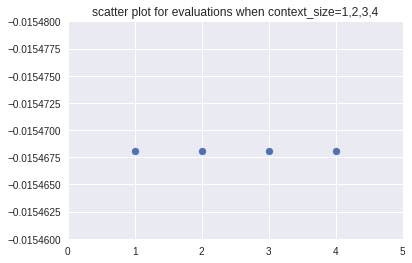

In [26]:
x=[1,2,3,4]
y=[evaluation1,evaluation2,evaluation3,evaluation4]
plt.scatter(x,y)
plt.xlim(0, 5)
plt.ylim(-0.01546, -0.01548)
plt.title("scatter plot for evaluations when context_size=1,2,3,4")

__c__. Briefly discuss the pros and cons of varying (i) the context size (ii) the vocabulary size (iii) using bigrams instead of unigrams (iv) using subword tokens instead of words. [8 pts]

(i) Generally, narrower window sizes lead to
better performance in syntactic tests while wider windows lead to
better performance in semantic tests. (this is a note from cs224n)
(ii)Performance increases with a larger vocabulary size; it takes more time to compute at the same time (iii)bigrams help machines learn meaning of words as two words combined might produce different meaning than seperated, however it only works well for word prediction if the test corpus looks like the training corpus (iv) using subword tokens reduces input size but loses some information

## 2. Pointwise Mutual Information [20 pts]

In lecture, we introduced __pointwise mutual information__ (PMI), which addresses the issue of normalization removing information about absolute magnitudes of counts. The PMI for word $\times$ context pair $(w,c)$ is 

$$\log\left(\frac{P(w,c)}{P(w) \cdot P(c)}\right)$$

with $\log(0) = 0$. This is a measure of how far that cell's value deviates from what we would expect given the row and column sums for that cell.

__a__. Implement `pmi`, a function which takes in a co-occurence matrix and returns the matrix with PMI normalization applied. [15 pts]

In [0]:
def pmi(mat):
    """Pointwise mutual information
    
    args:
        - mat: 2d np.array to apply PMI
        
    returns:
        - pmi_mat: matrix of same shape with PMI applied
       
    """
    
    sumofmat=np.sum(mat)
    mat=mat/sumofmat
    pmi = np.zeros((len(mat),len(mat[0])))
    Pw= np.sum(mat,axis=1).tolist()
    Pc= np.sum(mat,axis=0).tolist()
    for i in range(0,len(mat)):
      for j in range(0,len(mat[0])):
        if mat[i][j]==0 or Pw[i]==0 or Pc[j]==0:
          pmi[i][j]=0
        else:
          pmi[i][j]=np.log2(mat[i][j])-np.log2(Pw[i]*Pc[j])
    return pmi

Apply PMI to the co-occurence matrix computed above with `context_size=1`. What is the PMI between the words "the" and "end"?

In [28]:
mat_1

array([[11162,     0,     0, ...,     0,     0,     1],
       [    0,  9949,   466, ...,     0,     0,     0],
       [    0,   466,  8395, ...,     0,     0,     0],
       ...,
       [    0,     0,     0, ...,     2,     0,     0],
       [    0,     0,     0, ...,     0,     2,     0],
       [    1,     0,     0, ...,     0,     0,     2]])

In [29]:
pmi_mat1=pmi(mat_1)
pmi_mat1

array([[ 3.89301893,  0.        ,  0.        , ...,  0.        ,
         0.        ,  2.23549729],
       [ 0.        ,  2.91797937, -1.27537564, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -1.27537564,  3.11854748, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 15.02428358,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        15.02428358,  0.        ],
       [ 2.23549729,  0.        ,  0.        , ...,  0.        ,
         0.        , 15.02428358]])

calculate the PMI between the words "the" and "end"

In [30]:
#find the index of 'end'
list(tok2idx.keys()).index("end")

201

In [31]:
#find the index of 'the'
list(tok2idx.keys()).index("the")

2

In [32]:
pmi_mat1[2][201]

2.491290363137491

__b__. We also consider an extension of PMI, positive PMI (PPMI), that maps all negative PMI values to 0.0 ([Levy and Goldberg 2014](http://papers.nips.cc/paper/5477-neural-word-embedding-as-implicit-matrix-factorization)). 
Write `ppmi`, which is the same as `pmi` except it applies PPMI instead of PMI (feel free to implement it as an option of `pmi`). What is the PMI of the words "the" and "start"? The PPMI? [5 pts]

In [0]:
def ppmi(mat):
    """Pointwise mutual information
    
    args:
        - mat: 2d np.array to apply PMI
        
    returns:
        - pmi_mat: matrix of same shape with PMI applied
       
    """
    
    sumofmat=np.sum(mat)
    mat=mat/sumofmat
    ppmi = np.zeros((len(mat),len(mat[0])))
    def sumcol(mat):
      return [sum(col) for col in zip(*mat)]
    def sumrow(mat):
      return [sum(row) for row in zip(*mat)]
    Pw= sumrow(mat)
    Pc= sumcol(mat)
    for i in range(0,len(mat)):
      for j in range(0,len(mat[0])):
        if mat[i][j]==0 or Pw[i]==0 or Pc[j]==0:
          ppmi[i][j]=0
        else:
          if np.log2(mat[i][j])-np.log2(Pw[i]*Pc[j])>0:
            ppmi[i][j]=np.log2(mat[i][j])-np.log2(Pw[i]*Pc[j])
          else: ppmi[i][j]=0
    return ppmi

In [34]:
ppmi_mat1=ppmi(mat_1)
ppmi_mat1

array([[ 3.89301893,  0.        ,  0.        , ...,  0.        ,
         0.        ,  2.23549729],
       [ 0.        ,  2.91797937,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  3.11854748, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 15.02428358,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        15.02428358,  0.        ],
       [ 2.23549729,  0.        ,  0.        , ...,  0.        ,
         0.        , 15.02428358]])

In [35]:
#find the index of 'start'
list(tok2idx.keys()).index("start")

670

In [36]:
ppmi_mat1[2][670]

0.4214900105719579

## 3. Analyzing PMI [25 pts]

__a__. Consider the matrix `np.array([[1.0, 0.0, 0.0], [1000.0, 1000.0, 4000.0], [1000.0, 2000.0, 999.0]])`. Reweight this matrix using `ppmi`. (i) What is the value obtained for cell `[0,0]`, and (ii) give a brief description for what is likely problematic about this value. [10 pts]

In [0]:
array1=np.array([[1.0, 0.0, 0.0], [1000.0, 1000.0, 4000.0], [1000.0, 2000.0, 999.0]])

In [38]:
ppmi(array1)

array([[0.        , 0.        , 0.        ],
       [0.73624443, 0.15200309, 1.41532607],
       [0.        , 0.41532607, 0.        ]])

In [39]:
ppmi_array1=ppmi(array1)
ppmi_array1[0][0]

0.0

I'm not sure I noticed what's wrong but I assume some smoothing could be applied.

__b__. Give a suggestion for dealing with the problematic value and explain why it deals with this. Demonstrate your suggestion empirically [10 pts]

In [0]:
array2=array1+100

In [50]:
ppmi(array2)

array([[0.                 , 0.                 , 0.                 ],
       [0.6590327456064049 , 0.13882770469731653, 1.3536939877679455 ],
       [0.                 , 0.38845940592862194, 0.                 ]])

__c__. Consider starting with a word-word co-occurence matrix and applied PMI to this matrix. (i) Which of the following describe the resulting vectors: sparse, dense, high-dimensional, low-dimensional (ii) If you wanted the opposite style of representation, what could you do? [5 pts]


(i)sparse, high-dimensional
(ii)use truncated svd

## 4. Word Analogy Evaluation [25 pts]

Word analogies provide another kind of evaluation for distributed representations. Here, we are given three vectors A, B, and C, in the relationship

_A is to B as C is to __ _

and asked to identify the fourth that completes the analogy. These analogies are by and large substantially easier than the classic brain-teaser analogies that used to appear on tests like the SAT, but it's still an interesting, demanding
task. 

The core idea is that we make predictions by creating the vector

$$(A - B) + C$$ 

and then ranking all vectors based on their distance from this new vector, choosing the closest as our prediction.

__a__. Implement the function `analogy_completion`. [9 pts]

I can't upload the glove file to google colab because it is too large. However the first part of hw1 can not run on my local jupyter notebook, so I wrote this part on my local jupyter notebook, so here is no output saved.

In [0]:
def analogy_completion(a, b, c, vec):
    """Compute ? in 
    a is to b as c is to ? 
    as the closest to (b-a) + c
    """

    vector_a=vec[a]
    vector_b=vec[b]
    vector_c=vec[c]

    vector_d=vector_b-vector_a+vector_c
    distance={}
    for word in [x for x in vec.keys() if x not in [a,b,c]]:
        distance[word]=cosine(vector_d,vec[word])

    return min(distance.items(),key=operator.itemgetter(1))[0]
  

__b__. Our simple word embeddings likely won't perform well on this task. Let's instead look at some high quality pretrained word embeddings. Write code to load 300-dimensional [GloVe word embeddings](http://nlp.stanford.edu/data/glove.840B.300d.zip) trained on 840B tokens. Each line of the file is formatted as a word followed by 300 floats that make up its corresponding word embedding (all space delimited). The entries of GloVe word embeddings are not counts, but instead are learned via machine learning. Use your `analogy_completion` code to complete the following analogies using the GloVe word embeddings. [6 pts]

In [0]:
def load_glove(glove_file, n_vecs=20000):
    """ """
    tok2vec = {}
    with open(glove_file, 'r') as glove_fh:
        for i, row in enumerate(glove_fh):
            word, vec = row.split(' ', 1)
            tok2vec[word] = np.array([float(n) for n in vec.split(' ')])
            if i >= n_vecs:
                break
    return tok2vec


In [0]:
glove_file = "glove.840B.300d.txt"
glove_vecs = load_glove(glove_file, n_vecs=200000)

In [0]:
analogy_completion('study','hard','play',glove_vecs)

In [0]:
analogy_completion('beijing','china','paris',glove_vecs)

In [0]:
analogy_completion('gold','first','silver',glove_vecs)

In [0]:
analogy_completion('italian','mozzarella','american',glove_vecs)

In [0]:
analogy_completion('research','fun','engineering',glove_vecs)

- "Beijing" is to "China" as "Paris" is to ?
- "gold" is to "first" as "silver" is to ?
- "Italian" is to "mozzarella" as "American" is to ?
- "research" is to "fun" as "engineering" is to ?

c. Let's get a more quantitative, aggregate sense of the quality of GloVe embeddings. Load the analogies from `gram6-nationality-adjective.txt` and evaluate GloVe embeddings. Report the mean reciprocal rank of the correct answer (the last word on each line) for each analogy. [10 pts]

__Solution__

In [0]:
def load_word_dataset(data_file):
    with open(data_file, 'r') as data_fh:
        raw_data = data_fh.readlines()
    word1 = []
    word2=[]
    word3=[]
    trgs = []
 
 
    for i in range(0,len(raw_data),1): 
 
        list = []  
        for word in raw_data:
            
            word=raw_data[i].split()
            word1.append((word[0]))
            word2.append((word[1]))
            word3.append((word[2]))
            trgs.append((word[3]))

    return word1,word2,word3, trgs

In [0]:
def analogy_evaluation(glove_vecs, test_file, verbose=False):
    """Basic analogies evaluation for a file `src_filename `
    in `question-data/`.
    
    Parameters
    ----------    
    mat : 2d np.array
        The VSM being evaluated.
    rownames : list of str
        The names of the rows in `mat`.
        
    src_filename : str
        Basename of the file to be evaluated. It's assumed to be in
        `vsmdata_home`/question-data.
        
    distfunc : function mapping vector pairs to floats (default: `cosine`)
        The measure of distance between vectors. Can also be `euclidean`, 
        `matching`, `jaccard`, as well as any other distance measure 
        between 1d vectors.
    
    Returns
    -------
    (float, float)
        The first is the mean reciprocal rank of the predictions and 
        the second is the accuracy of the predictions.
    
    """
    def analogy2(a,b,c,d,vec):
        

        vector_a=vec[a]
        vector_b=vec[b]
        vector_c=vec[c]
        vector_d=vector_b-vector_a+vector_c
        distance={}
        
        for word in [x for x in vec.keys() if x not in [a,b,c]]:
            distance[word]=cosine(vector_d,vec[word])
            sorted_distance=sorted(distance.items(), key=lambda t: t[1])
        for index,value in enumerate(sorted_distance):
            if value[0]==d:
                ind=index
        return ind[0]

    wordlist1, wordlist2,wordlist3, trglist=load_word_dataset(data_file)
    n_exs = 0
    for word1,word2,word3,trg in zip(wordlist1,wordlist2,wordlist3,trglist):
        
            rank_ = analogy2(word1,word2,word3,trglist,glove_vecs)+1
            rank.append(rank_)
            n_exs += 1
    
    rank=np.array(rank)
    accuracy=sum(rank==1)/(len(rank))
    mean=np.mean(1/rank)
    

    print("Evaluated on %d of %d examples" % (n_exs, len(trglist)))
    return accuracy,mean

In [0]:
analogy_evaluation(glove_vecs, "gram6-nationality-adjective.txt")

(0.9391509433962264, defaultdict(int, {True: 97, False: 9}))